In [1]:
%matplotlib ipympl
import sys
sys.path.append('../scripts/')
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0]*math.sqrt(abs(nu)/time) + ns[1]*math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2]*math.sqrt(abs(nu)/time) + ns[3]*math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
        #self.pose = IdealRobot.state_transition(nu, omega, time, self.pose)
    
    def observation_update(self, observation):
        print("obs")
        print(observation)
        #print("obs")
    

In [3]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds={"nn":0.1, "no":0.001, "on":0.1, "oo":0.2}):
        self.particles = [Particle(init_pose, 1.0 / num) for i in range(num)]

        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov = c)

    def motion_update(self, nu,omega, time):
        #print(self.motion_noise_rate_pdf.cov)
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
    #5.4.1
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation)
    
    def draw(self,ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs,ys,vxs,vys,color="blue", alpha=0.5))

In [7]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def draw(self, ax, elems):
        #elems.append(ax.text(0,0,"hoge", fontsize=10))
        self.estimator.draw(ax, elems)
    
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)#5.4.1
        return self.nu, self.omega

In [8]:
world = World(30,0.1)

m = Map()
for ln in [(-4,2),(2,-3),(3,3)]: 
    m.append_landmark(Landmark(*ln))
world.append(m)

initial_pose = np.array([2,2,math.pi/6]).T
estimator = Mcl(initial_pose,100)
circling = EstimationAgent(0.2, 10.0/180*math.pi,estimator)
r = Robot(initial_pose, sensor=Camera(m), agent=circling)
world.append(r)
world.draw()

TypeError: EstimationAgent.__init__() missing 1 required positional argument: 'estimator'

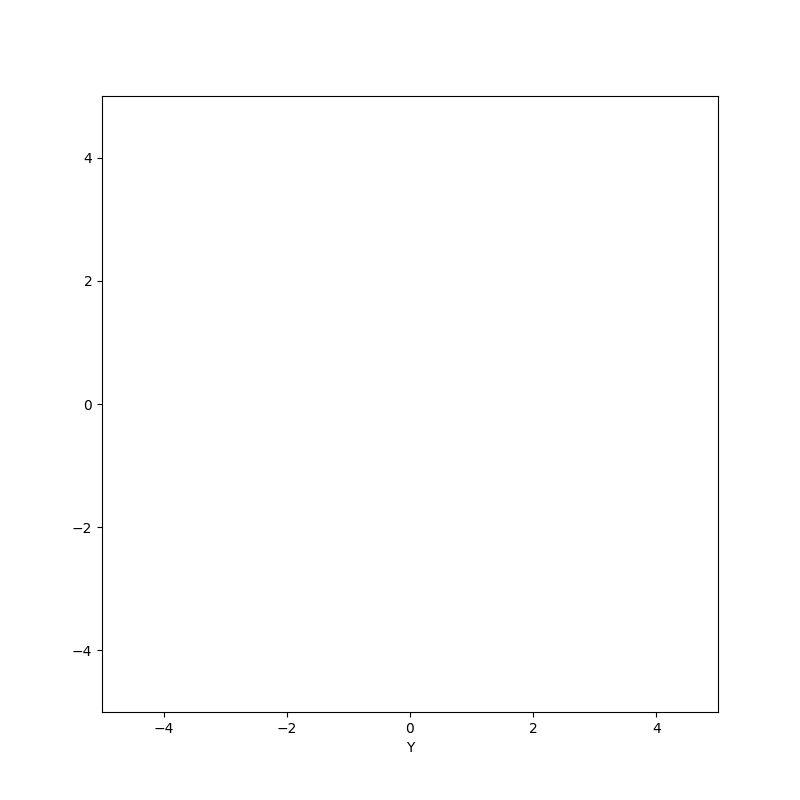

In [9]:
def trial(motion_noise_stds):
    time_interval=0.1
    world = World(30, time_interval)
    
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi,estimator)
    r = Robot(initial_pose, sensor = None, agent=circling, color = "red")
    world.append(r)

    world.draw()
'''
sigma_wv = 0.1
sigma_vv = 0.22
sigma_ww = 0.20
'''
trial({"nn":0.1, "no":0.001, "on":0.1, "oo":0.2})

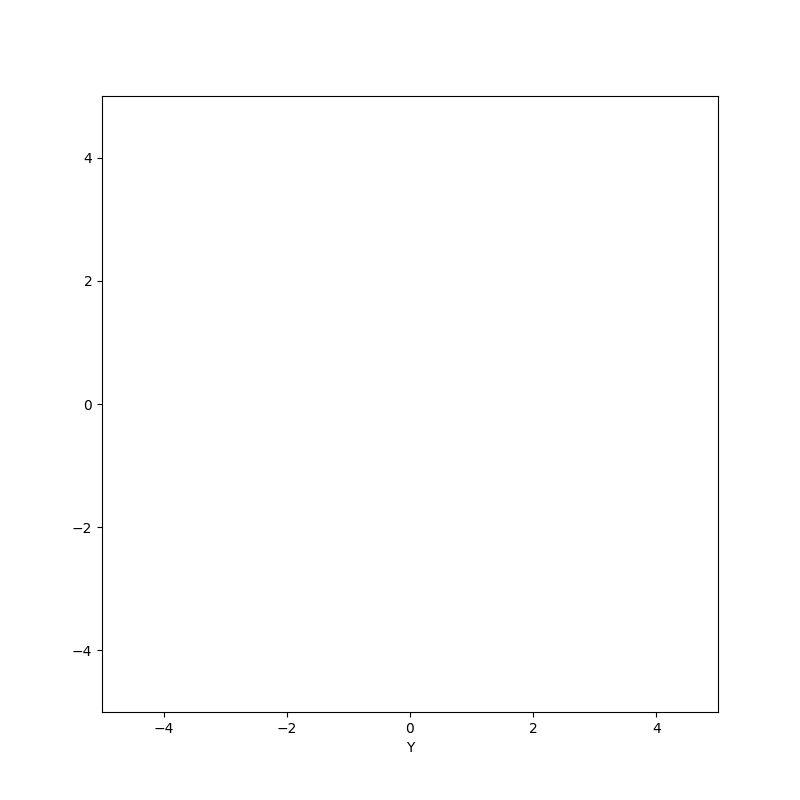

In [40]:
#ロボットのパラメタを求めるシミュレーション1/3
import copy

world = World(40.0, 0.1)

initial_pose = np.array([0,0,0]).T
robots = []
r = Robot(initial_pose, sensor = None, agent = Agent(0.1, 0.0))

for i in range(100):
    #copy_r = copy.copy(r)
    #copy_r.distance_until_noise = copy_r.noise_pdf.rvs()
    copy_r = Robot(initial_pose, sensor = None, agent = Agent(0.0, 0.1))
    world.append(copy_r)
    robots.append(copy_r)
world.draw()

In [46]:
#ロボットのパラメタを求めるシミュレーション2/3
import pandas as pd
poses = pd.DataFrame([[math.sqrt(r.pose[0]**2 + r.pose[1]**2), r.pose[2]] for r in robots], columns=['r', 'theta'])
poses.transpose()


0         1         2         3         4         5         6   \
r      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
theta  3.854165  3.667472  4.129341  4.362382  4.007219  4.159389  4.180844   

             7         8         9   ...        90        91        92  \
r      0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
theta  3.932785  4.250603  3.777204  ...  4.373541  3.588364  3.797337   

             93        94        95       96        97        98        99  
r      0.000000  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  
theta  3.711181  3.536086  3.814924  4.13413  4.290253  3.645716  4.809206  

[2 rows x 100 columns]

In [47]:
#ロボットのパラメタを求めるシミュレーション3/3
print(poses["theta"].var())
print(poses["r"].mean())
math.sqrt(poses["theta"].var() / poses["theta"].mean())

0.158032654162205
0.0


0.19670717707800278

obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs
[(array([ 4.31697795, -0.9973268 ]), 2), (array([4.37045731, 0.78708754]), 3)]
obs


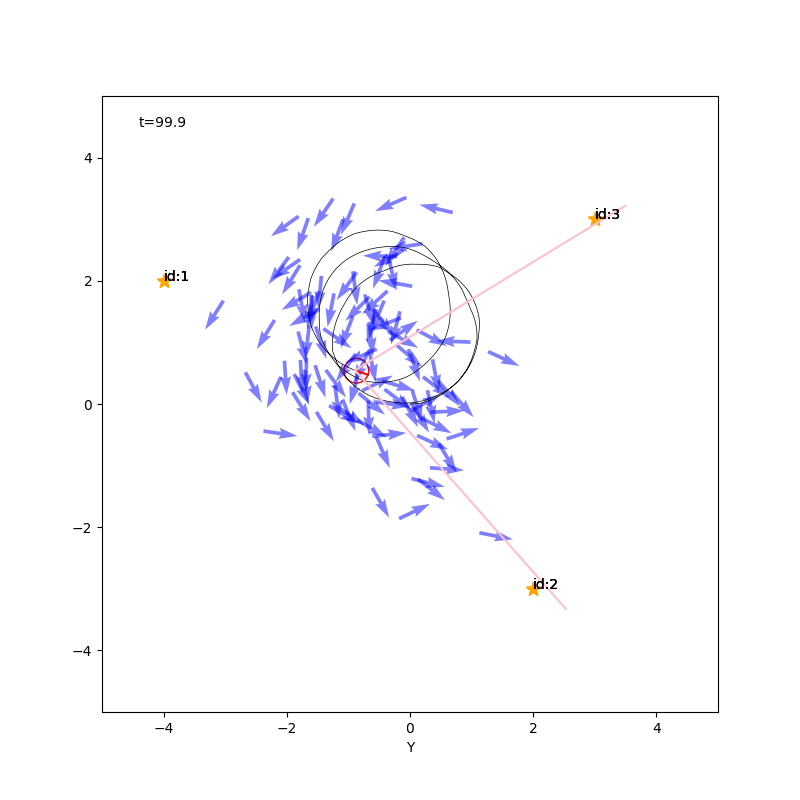

In [15]:
#5.4.1
def trial():
    time_interval=0.1
    world = World(30, time_interval, debug=False)
    
    #地図を生成
    m = Map()
    for ln in [(-4,2),(2,-3),(3,3)]:
        m.append_landmark(Landmark(*ln))
        world.append(m)

    #ロボットを作る
    initial_pose = np.array([0,0,0]).T
    estimator = Mcl(initial_pose,100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi,estimator)
    r = Robot(initial_pose, sensor = Camera(m), agent=a, color = "red")
    world.append(r)

    world.draw()
'''
sigma_wv = 0.1
sigma_vv = 0.22
sigma_ww = 0.20
'''
trial()